In [2]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import math
import csv
import math
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

In [3]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/2x2_outputs/2x2_2p2h_output_1.2.root")
#tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/minirun6_caf_outputs/2p2h_eff_output.root")
tracks["CafTree"].show()
tracks["CafTree"].keys()

branches = tracks["CafTree"].arrays()[0]
file_index = branches['file_index']
print(np.unique(file_index))

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

In [4]:
reco_protons = 0
p_theta = []
candidate_files = []
p2 = []
hammer = 0
eventsperfile = []
reco_protons_file = []
totalevents = 0
proton_momenta = []

#Function to find angle between 2 (momentum) vectors
#Using dot product
def mag(x):
    return np.sqrt(np.sum(i ** 2 for i in x))

def theta(track1, track2):
    cos = np.dot(track1, track2) / (mag(track1) * mag(track2))
    cos = np.clip(cos, -1, 1)
    #p_theta = np.arccos(cos)
    return cos

def is_contained(x, y, z):
    tpc_dist = 8.0 #distance from the tpc wallsfor containment cuts
    xbound = 63.931
    ybound = 62.076
    zbound = 64.3163

    cont = False

    if abs(x) < xbound - tpc_dist and abs(y) < ybound - tpc_dist and abs(z) < zbound - tpc_dist:
        cont = True

    return cont

Loop through files and events and record data of interest

In [5]:
#Loop through each file index
for file_idx in np.unique(file_index):
    reco_energy = branches['reco_energy'][file_index == file_idx]
    reco_p_x = branches['reco_p_x'][file_index == file_idx]
    reco_p_y = branches['reco_p_y'][file_index == file_idx]
    reco_p_z = branches['reco_p_z'][file_index == file_idx]
    reco_p_mag = branches['reco_p_mag'][file_index == file_idx]
    reco_length = branches['reco_length'][file_index == file_idx]
    reco_angle = branches['reco_angle'][file_index == file_idx]
    reco_angle_rot = branches['reco_angle_rot'][file_index == file_idx]
    reco_angle_incl = branches['reco_angle_incl'][file_index == file_idx]
    reco_angle_x = branches['reco_angle_x'][file_index == file_idx]
    reco_angle_y = branches['reco_angle_y'][file_index == file_idx]
    reco_angly_z = branches['reco_angle_z'][file_index == file_idx]
    reco_track_start_x = branches['reco_track_start_x'][file_index == file_idx]
    reco_track_start_y = branches['reco_track_start_y'][file_index == file_idx]
    reco_track_start_z = branches['reco_track_start_z'][file_index == file_idx]
    reco_track_end_x = branches['reco_track_end_x'][file_index == file_idx]
    reco_track_end_y = branches['reco_track_end_y'][file_index == file_idx]
    reco_track_end_z = branches['reco_track_end_z'][file_index == file_idx]
    reco_pdg = branches['reco_pdg'][file_index == file_idx]
    reco_ixn_index = branches['reco_ixn_index'][file_index == file_idx]
    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in np.unique(event):
        totalevents += 1

        reco_energy_ev = np.array(reco_energy[event == ev])
        reco_p_x_ev = np.array(reco_p_x[event == ev])
        reco_p_y_ev = np.array(reco_p_y[event == ev])
        reco_p_z_ev = np.array(reco_p_z[event == ev])
        reco_p_mag_ev = np.array(reco_p_mag[event == ev])
        reco_track_start_x_ev = np.array(reco_track_start_x[event == ev])
        reco_track_start_y_ev = np.array(reco_track_start_y[event == ev])
        reco_track_start_z_ev = np.array(reco_track_start_z[event == ev])
        reco_track_end_x_ev = np.array(reco_track_end_x[event == ev])
        reco_track_end_y_ev = np.array(reco_track_end_y[event == ev])
        reco_track_end_z_ev = np.array(reco_track_end_z[event == ev])
        reco_pdg_ev = np.array(reco_pdg[event == ev])

        x_track = []
        y_track = []
        z_track = []
        p_mag = []

        #Loop through particles
        for i in range(len(reco_track_start_z_ev)):
            if reco_pdg_ev[i] == 2212:
                p_mag.append(reco_p_mag_ev[i])
                x_track.append(reco_track_end_x_ev[i] - reco_track_start_x_ev[i])
                y_track.append(reco_track_end_y_ev[i] - reco_track_start_y_ev[i])
                z_track.append(reco_track_end_z_ev[i] - reco_track_start_z_ev[i])

                #Record proton momenta
                proton_momenta.append(reco_p_mag_ev[i])
            

        #Compare angles
            
        #Compare only top 2 momenta protons
        p_mag, x_track, y_track, z_track = zip(*sorted(zip(p_mag, x_track, y_track, z_track), reverse=True))
        track1 = [x_track[0], y_track[0], z_track[0]]
        track2 = [x_track[1], y_track[1], z_track[1]]
        angle = theta(track1, track2)
        if angle <= -0.95:
            candidate_files.append(file_idx)
        p_theta.append(angle)

        #Compare all protons
        """  
        for i in range(len(z_track) - 1):
            for j in range(i+1, len(z_track)):
                track1 = [x_track[i], y_track[i], z_track[i]]
                track2 = [x_track[j], y_track[j], z_track[j]]
                angle = theta(track1, track2)
                if angle <= -0.95:
                    candidate_files.append(file_idx)
                p_theta.append(angle)
        """

/tmp/ipykernel_1771494/3571085011.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i ** 2 for i in x))


Angles

Files with candidate events:  []


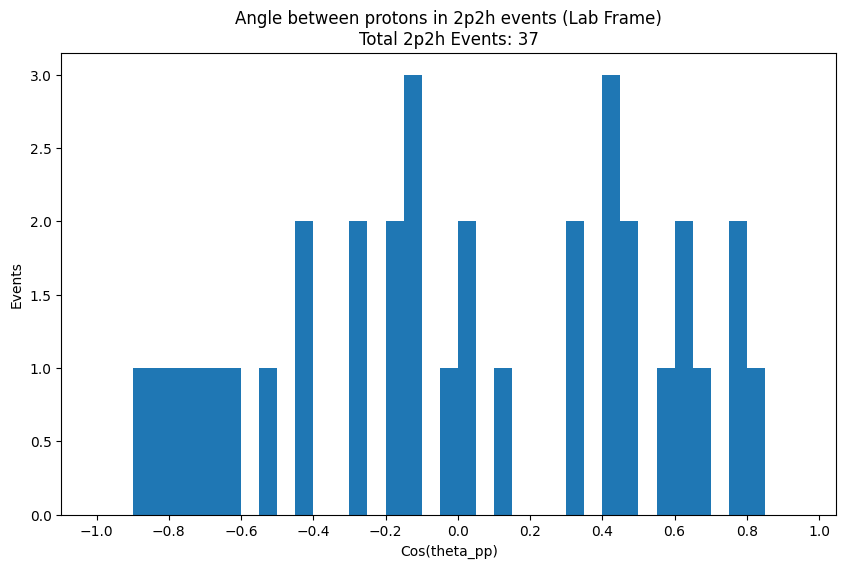

In [6]:
candidates = 0
for value in p_theta:
    if value < -0.95:
        candidates += 1
print("Files with candidate events: ", (np.array(candidate_files)))
fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(p_theta, bins=np.arange(-1.0, 1.0, 0.05))
plt.xticks(np.arange(-1.0, 1.1, 0.2))
plt.xlabel("Cos(theta_pp)")
plt.ylabel("Events")
plt.title("Angle between protons in 2p2h events (Lab Frame)\nTotal 2p2h Events: {}".format(totalevents))
#plt.title("Angle between protons in 2p2h events (Lab Frame)\nTotal Hammer Events: {}".format(candidates))
plt.show()

Proton Momenta

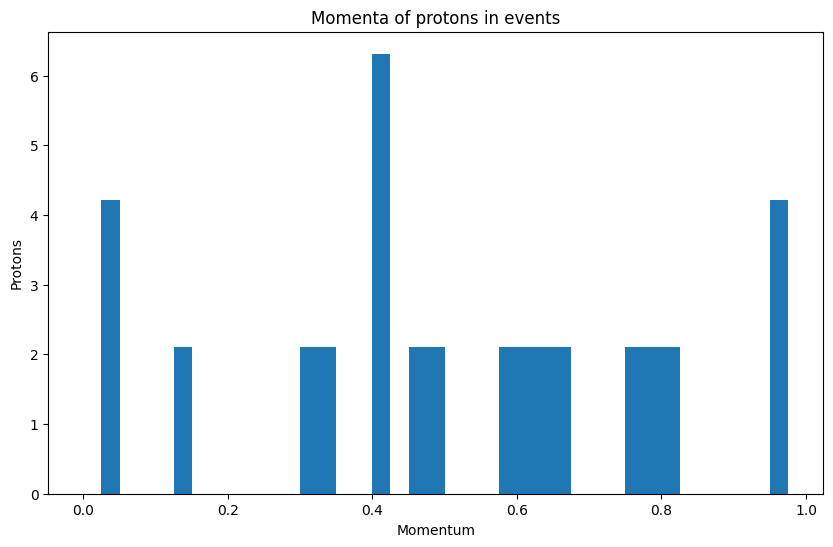

In [7]:
fig = plt.figure(figsize=(10,6))
n, bins, edges = plt.hist(p_theta, bins=np.arange(0.0, 1.0, 0.025), density=True)
#plt.xticks(np.arange(-1.0, 1.1, 0.2))
plt.xlabel("Momentum")
plt.ylabel("Protons")
plt.title("Momenta of protons in events")
plt.show()
#IS THIS ALREADY NORMALIZED?

Event Display

Event #:  [55, 110, 288, 378, 414] 

Event:  55 , # of Tracks:  6 

Event:  110 , # of Tracks:  7 

Event:  288 , # of Tracks:  5 

Event:  378 , # of Tracks:  14 

Event:  414 , # of Tracks:  9 



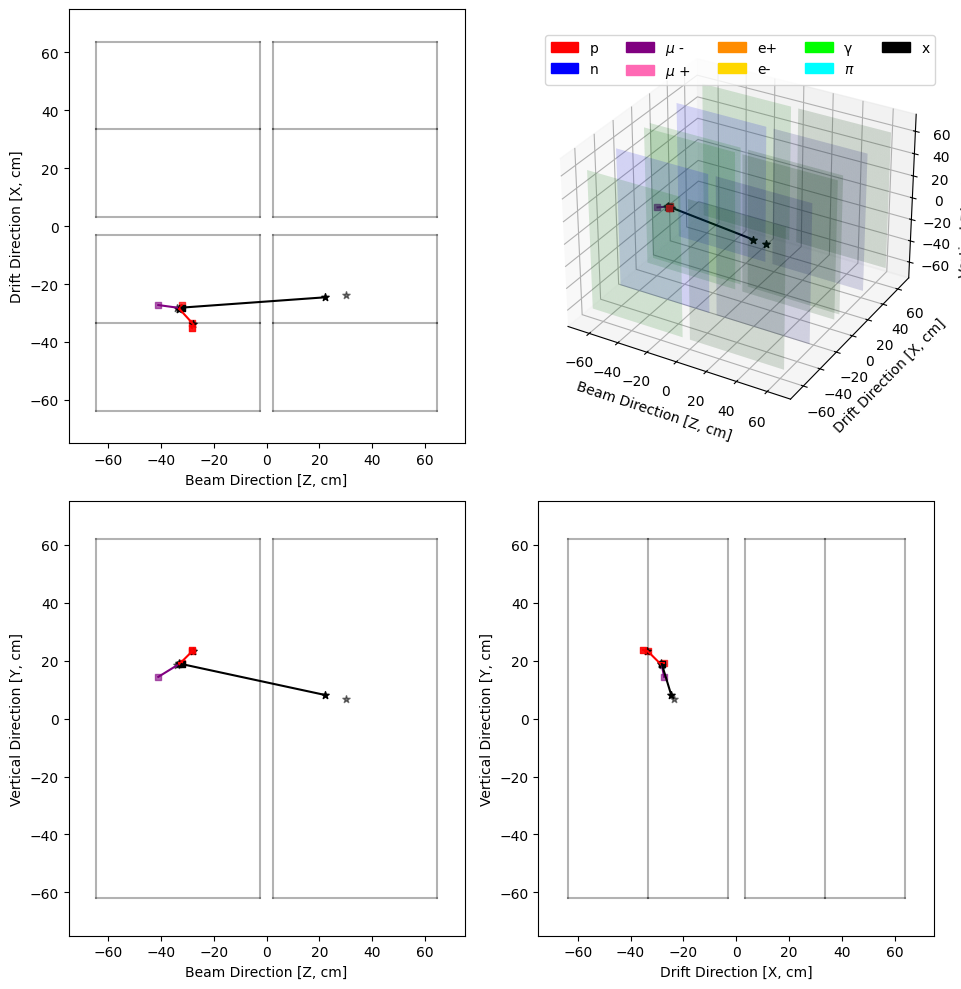

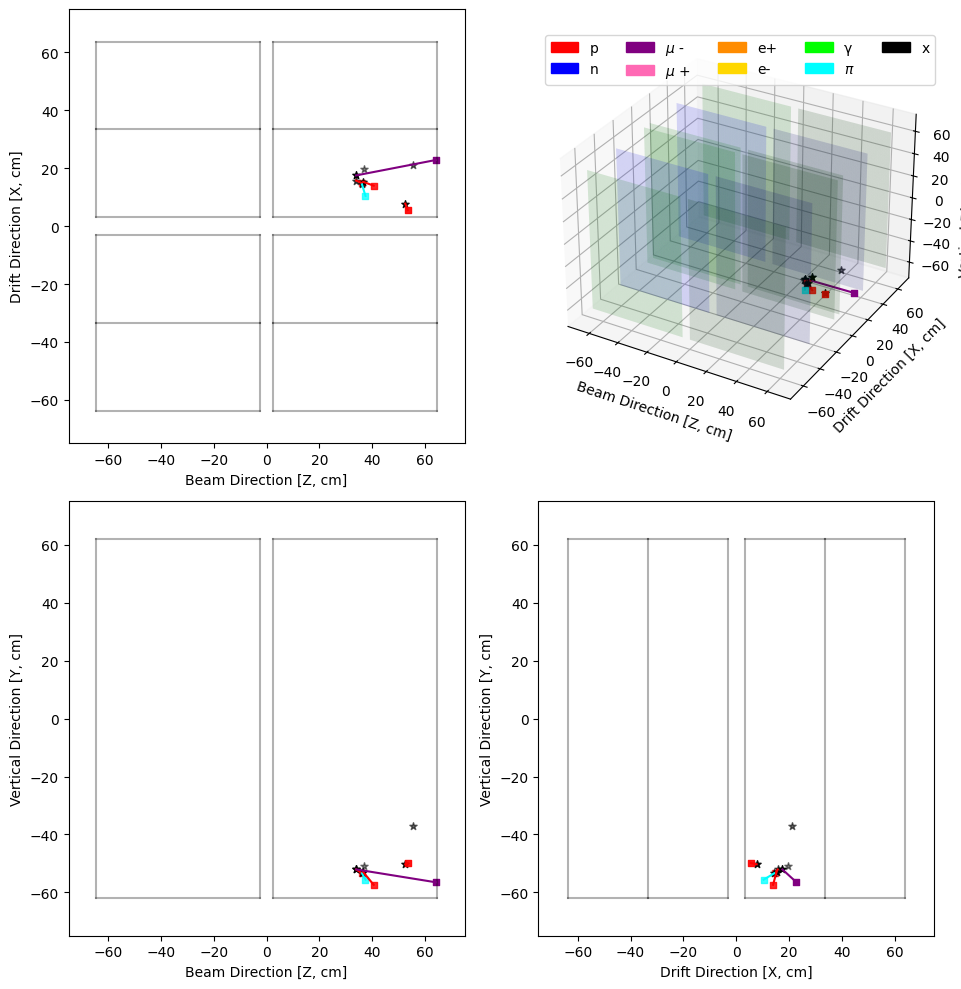

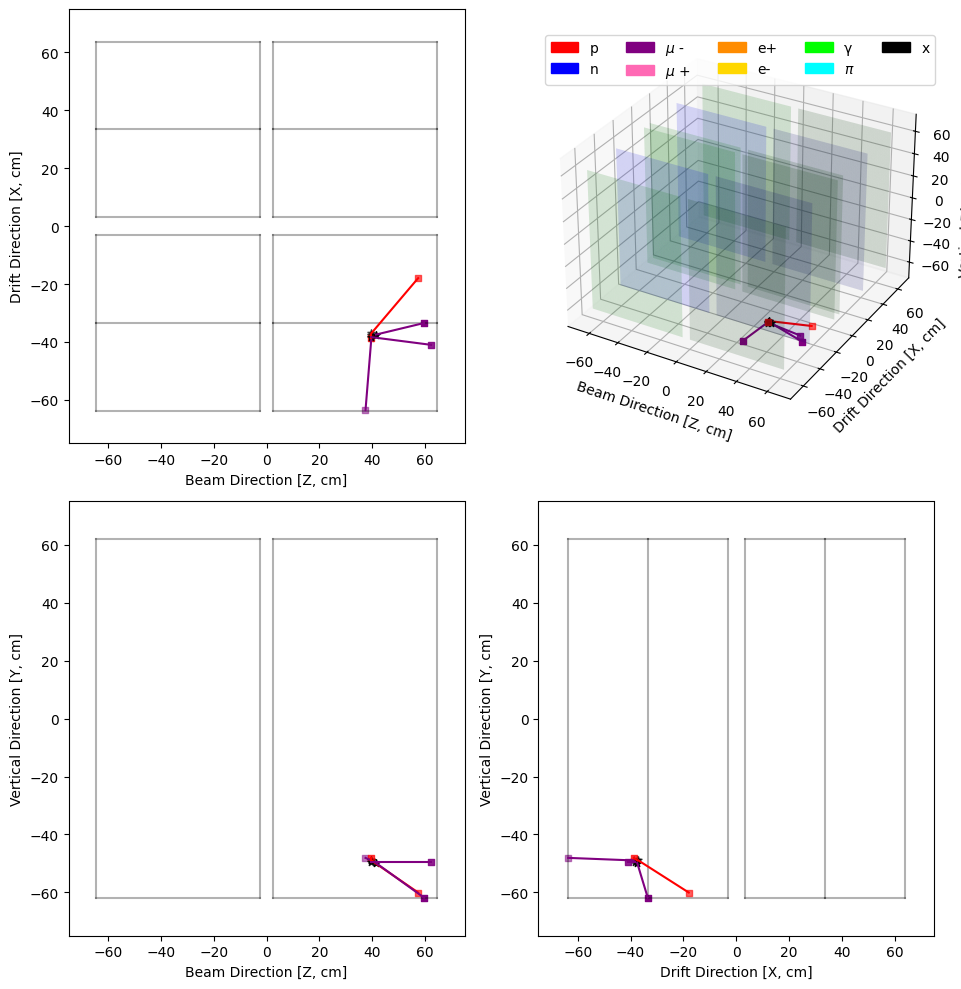

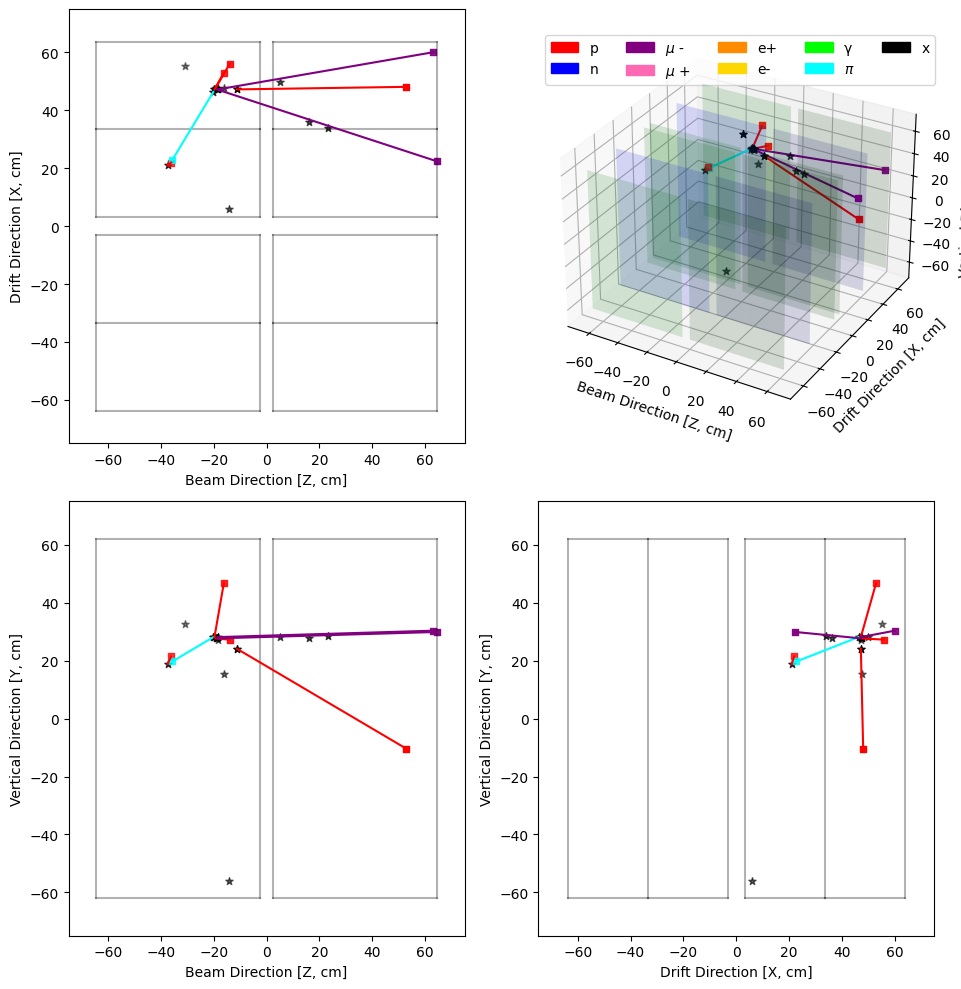

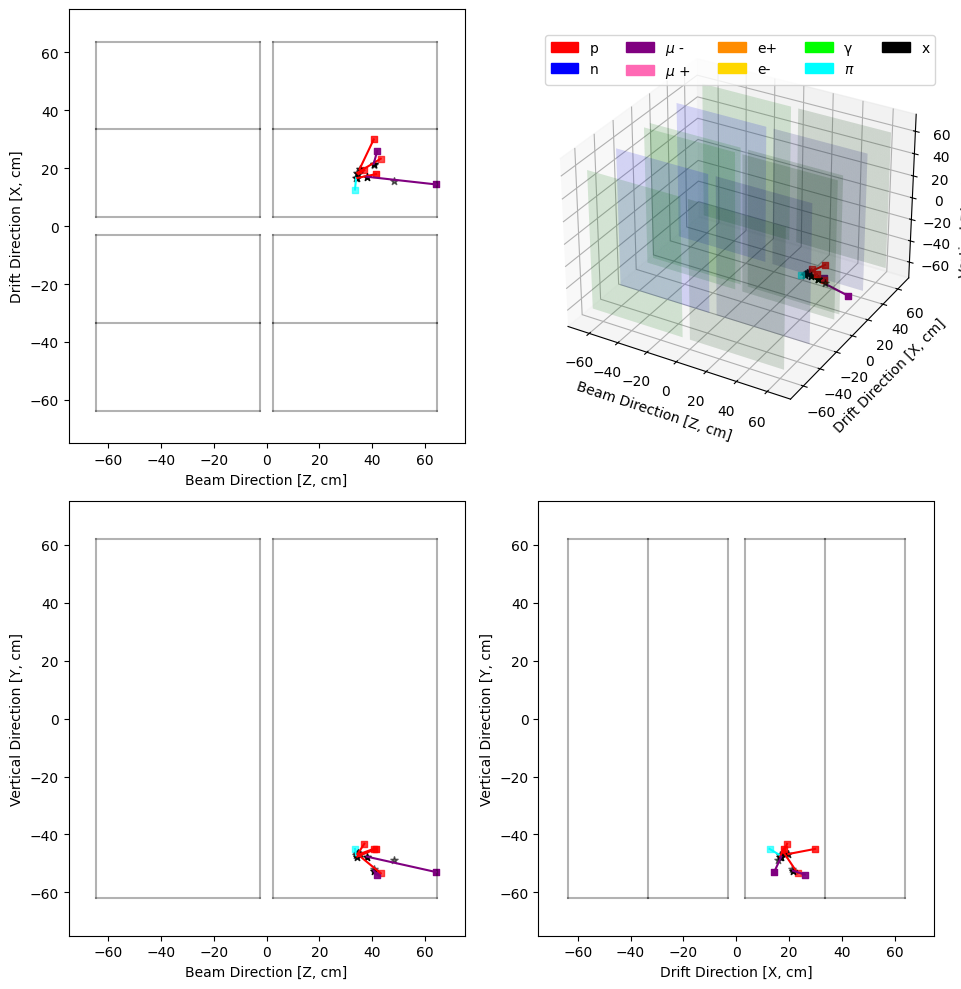

In [9]:
fidx = 3

reco_energy = branches['reco_energy'][file_index == fidx]
reco_p_x = branches['reco_p_x'][file_index == fidx]
reco_p_y = branches['reco_p_y'][file_index == fidx]
reco_p_z = branches['reco_p_z'][file_index == fidx]
reco_p_mag = branches['reco_p_mag'][file_index == fidx]
reco_length = branches['reco_length'][file_index == fidx]
reco_angle = branches['reco_angle'][file_index == fidx]
reco_angle_rot = branches['reco_angle_rot'][file_index == fidx]
reco_angle_incl = branches['reco_angle_incl'][file_index == fidx]
reco_angle_x = branches['reco_angle_x'][file_index == fidx]
reco_angle_y = branches['reco_angle_y'][file_index == fidx]
reco_angly_z = branches['reco_angle_z'][file_index == fidx]
reco_track_start_x = branches['reco_track_start_x'][file_index == fidx]
reco_track_start_y = branches['reco_track_start_y'][file_index == fidx]
reco_track_start_z = branches['reco_track_start_z'][file_index == fidx]
reco_track_end_x = branches['reco_track_end_x'][file_index == fidx]
reco_track_end_y = branches['reco_track_end_y'][file_index == fidx]
reco_track_end_z = branches['reco_track_end_z'][file_index == fidx]
reco_pdg = branches['reco_pdg'][file_index == fidx]
reco_ixn_index = branches['reco_ixn_index'][file_index == fidx]
spill_index = branches['spill_index'][file_index == fidx]
event = branches['event'][file_index == fidx]
subrun = branches['subrun'][file_index == fidx]
caf_file_name = branches['caf_file_name'][file_index == fidx]

print("Event #: ", np.unique(event), "\n")

unique_event = np.unique(event)

for ev in unique_event:
    reco_energy_ev = np.array(reco_energy[event == ev])
    reco_p_x_ev = np.array(reco_p_x[event == ev])
    reco_p_y_ev = np.array(reco_p_y[event == ev])
    reco_p_z_ev = np.array(reco_p_z[event == ev])
    reco_p_mag_ev = np.array(reco_p_mag[event == ev])
    reco_track_start_x_ev = np.array(reco_track_start_x[event == ev])
    reco_track_start_y_ev = np.array(reco_track_start_y[event == ev])
    reco_track_start_z_ev = np.array(reco_track_start_z[event == ev])
    reco_track_end_x_ev = np.array(reco_track_end_x[event == ev])
    reco_track_end_y_ev = np.array(reco_track_end_y[event == ev])
    reco_track_end_z_ev = np.array(reco_track_end_z[event == ev])
    reco_pdg_ev = np.array(reco_pdg[event == ev])

    print("Event: ", ev, ", # of Tracks: ",len(reco_track_start_z_ev), "\n")

    color = []

    for pdg in reco_pdg_ev:
        if (pdg == 2212): #Proton
            color.append('red')
        elif (pdg == 2112): #Neutron
            color.append('blue')
        elif (pdg == 13): #mu-
            color.append('purple')
        elif (pdg == -13): #mu+
            color.append('hotpink')
        elif (pdg == -11): #e+
            color.append('darkorange')
        elif (pdg == 11): #e-
            color.append('gold')
        elif (pdg == 22): #photon
            color.append('lime')
        elif (pdg == 111 or pdg == 211 or pdg == -211): #pions
            color.append('cyan')
        else: #x
            color.append('black')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(222, projection='3d')
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)

    def make_cathode_or_anode(y1, y2, z1, z2, x):
        y = np.linspace(y1, y2, 100)
        z = np.linspace(z1, z2, 100)
        Y, Z = np.meshgrid(y, z)
        X = np.full(Y.shape, x)
        return X, Y, Z

    #Make alpha list from linspace or something similar that is based on the length of true start z all
    alphas = np.linspace(0.5, 1.0, len(reco_track_start_z_ev))

    # Plot TPC Surfaces
    anode_y1s = [-62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076, -62.076]
    anode_y2s = [62.076, 62.076, 62.076, 62.076, 62.076, 62.076, 62.076,62.076]
    anode_z1s = [2.462, 2.462, 2.462, 2.462, -2.462, -2.462, -2.462, -2.462]
    anode_z2s = [2.462+62.076, 2.462+62.076, 2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076, -2.462-62.076]
    anode_xs = [33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225, 33.5+30.27225, -33.5+30.27225, 33.5-30.27225, -33.5-30.27225]

    cathode_y1s = [-62.076, -62.076, -62.076, -62.076]
    cathode_y2s = [62.076, 62.076, 62.076, 62.076]
    cathode_z1s = [2.462, 2.462, -2.462, -2.462]
    cathode_z2s = [2.462+62.076, 2.462+62.076, -2.462-62.076, -2.462-62.076]
    cathode_xs = [33.5, -33.5, 33.5, -33.5]


    for i in range(len(cathode_y1s)):
        X_cathode, Y_cathode, Z_cathode = make_cathode_or_anode(cathode_y1s[i], cathode_y2s[i], cathode_z1s[i], cathode_z2s[i], cathode_xs[i])
        ax.plot_surface(Z_cathode,X_cathode,Y_cathode, color='b', alpha=0.15)
    for i in range(len(anode_y1s)):
        X_anode, Y_anode, Z_anode = make_cathode_or_anode(anode_y1s[i], anode_y2s[i], anode_z1s[i], anode_z2s[i], anode_xs[i])
        ax.plot_surface(Z_anode,X_anode,Y_anode, color='g', alpha=0.15)

    ax.set_xlabel('Beam Direction [Z, cm]')
    ax.set_ylabel('Drift Direction [X, cm]')
    ax.set_zlabel('Vertical Direction [Y, cm]')

    # Plot outlines of detector for projections:
    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[0], anode_z1s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[0], anode_z2s[0]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[0], anode_z2s[0]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[0], anode_z2s[0]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[0], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[0], anode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[2], cathode_xs[0]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[2], anode_xs[2]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[0], cathode_xs[0]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[1], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[1], anode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.plot([anode_z1s[-1], anode_z1s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z2s[-1], anode_z2s[-1]], [anode_xs[3], cathode_xs[1]], color='k', alpha=0.3)
    ax1.plot([anode_z1s[-1], anode_z2s[-1]], [anode_xs[3], anode_xs[3]], color='k', alpha=0.3)
    #ax1.plot([anode_z1s[-1], anode_z2s[-1]], [cathode_xs[1], cathode_xs[1]], color='k', alpha=0.3)

    ax1.set_xlabel('Beam Direction [Z, cm]')
    ax1.set_ylabel('Drift Direction [X, cm]')

    ax2.plot([anode_z1s[-1], anode_z1s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z1s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z2s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z2s[0], anode_z2s[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[-1], anode_z2s[-1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax2.plot([anode_z1s[0], anode_z2s[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)

    ax2.set_xlabel('Beam Direction [Z, cm]')
    ax2.set_ylabel('Vertical Direction [Y, cm]')


    ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], cathode_xs[0]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], cathode_xs[1]], [anode_y1s[0], anode_y1s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[0], cathode_xs[0]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], cathode_xs[1]], [anode_y2s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[0], anode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[1], anode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[2], anode_xs[2]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([anode_xs[3], anode_xs[3]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([cathode_xs[0], cathode_xs[0]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)
    ax3.plot([cathode_xs[1], cathode_xs[1]], [anode_y1s[0], anode_y2s[0]], color='k', alpha=0.3)

    ax3.set_xlabel('Drift Direction [X, cm]')
    ax3.set_ylabel('Vertical Direction [Y, cm]')

    for i in range(len(reco_track_start_z_ev)):

        true_start_x, true_end_x = reco_track_start_x_ev[i], reco_track_end_x_ev[i]
        true_start_y, true_end_y = reco_track_start_y_ev[i], reco_track_end_y_ev[i]
        true_start_z, true_end_z = reco_track_start_z_ev[i], reco_track_end_z_ev[i]

        ax.plot([true_start_z, true_end_z], [true_start_x, true_end_x], [true_start_y, true_end_y],
                color=color[i])
        if i==0:
            ax.scatter(true_start_z, true_start_x, true_start_y, color='black', marker='*', s=30, label='True Match Start')
            ax.scatter(true_end_z, true_end_x, true_end_y, color=color[i], marker='s', s=25, label='True Match End')
        else:
            ax.scatter(true_start_z, true_start_x, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
            ax.scatter(true_end_z, true_end_x, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)
        ax1.plot([true_start_z, true_end_z], [true_start_x, true_end_x], color=color[i])
        ax1.scatter(true_start_z, true_start_x, color='black', alpha=alphas[i], marker='*', s=30)
        ax1.scatter(true_end_z, true_end_x, color=color[i], alpha=alphas[i], marker='s', s=25)

        ax2.plot([true_start_z, true_end_z], [true_start_y, true_end_y],  color=color[i])
        ax2.scatter(true_start_z, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
        ax2.scatter(true_end_z, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)

        ax3.plot([true_start_x, true_end_x], [true_start_y, true_end_y], color=color[i])
        ax3.scatter(true_start_x, true_start_y, color='black', alpha=alphas[i], marker='*', s=30)
        ax3.scatter(true_end_x, true_end_y, color=color[i], alpha=alphas[i], marker='s', s=25)

    #set bound limits for all plots
    ax1.set_xlim(-75, 75)
    ax1.set_ylim(-75, 75)
    ax2.set_xlim(-75, 75)
    ax2.set_ylim(-75, 75)
    ax3.set_xlim(-75, 75)
    ax3.set_ylim(-75, 75)

    ax.set_xlim3d(-75, 75)
    ax.set_ylim3d(-75, 75)
    ax.set_zlim3d(-75, 75)


    red_patch = mpatches.Patch(color='red', label='p')
    blue_patch = mpatches.Patch(color='blue', label='n')
    purple_patch = mpatches.Patch(color='purple', label=r'$\mu$ -')
    pink_patch = mpatches.Patch(color='hotpink', label=r'$\mu$ +')
    orange_patch = mpatches.Patch(color='darkorange', label='e+')
    gold_patch = mpatches.Patch(color='gold', label='e-')
    green_patch = mpatches.Patch(color='lime', label='\u03B3')
    cyan_patch = mpatches.Patch(color='cyan', label=r'$\pi$')
    black_patch = mpatches.Patch(color='black', label='x')
    ax.legend(loc='upper left', ncol=5, handles=[red_patch, blue_patch, purple_patch, pink_patch, orange_patch, gold_patch, green_patch, cyan_patch, black_patch])
    plt.tight_layout()